Dataset shape: (4424, 37)

Processing Multi-Input Neural Network
All Features without SMOTE...
Epoch 1/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4736 - loss: 1.3117 - val_accuracy: 0.6963 - val_loss: 0.8322 - learning_rate: 0.0010
Epoch 2/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6064 - loss: 0.9549 - val_accuracy: 0.7189 - val_loss: 0.7349 - learning_rate: 0.0010
Epoch 3/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6662 - loss: 0.8477 - val_accuracy: 0.7161 - val_loss: 0.6889 - learning_rate: 0.0010
Epoch 4/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6780 - loss: 0.7984 - val_accuracy: 0.7218 - val_loss: 0.6645 - learning_rate: 0.0010
Epoch 5/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6951 - loss: 0.7649 - val_accuracy: 0.7486 - val_loss: 0.6203 - learning_rate: 0.0010
Epoch 6/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7224 - loss: 0.7204 - val_accuracy: 0.7528 - val_loss: 0.6193 - learning_rate: 0.0010
Epoch

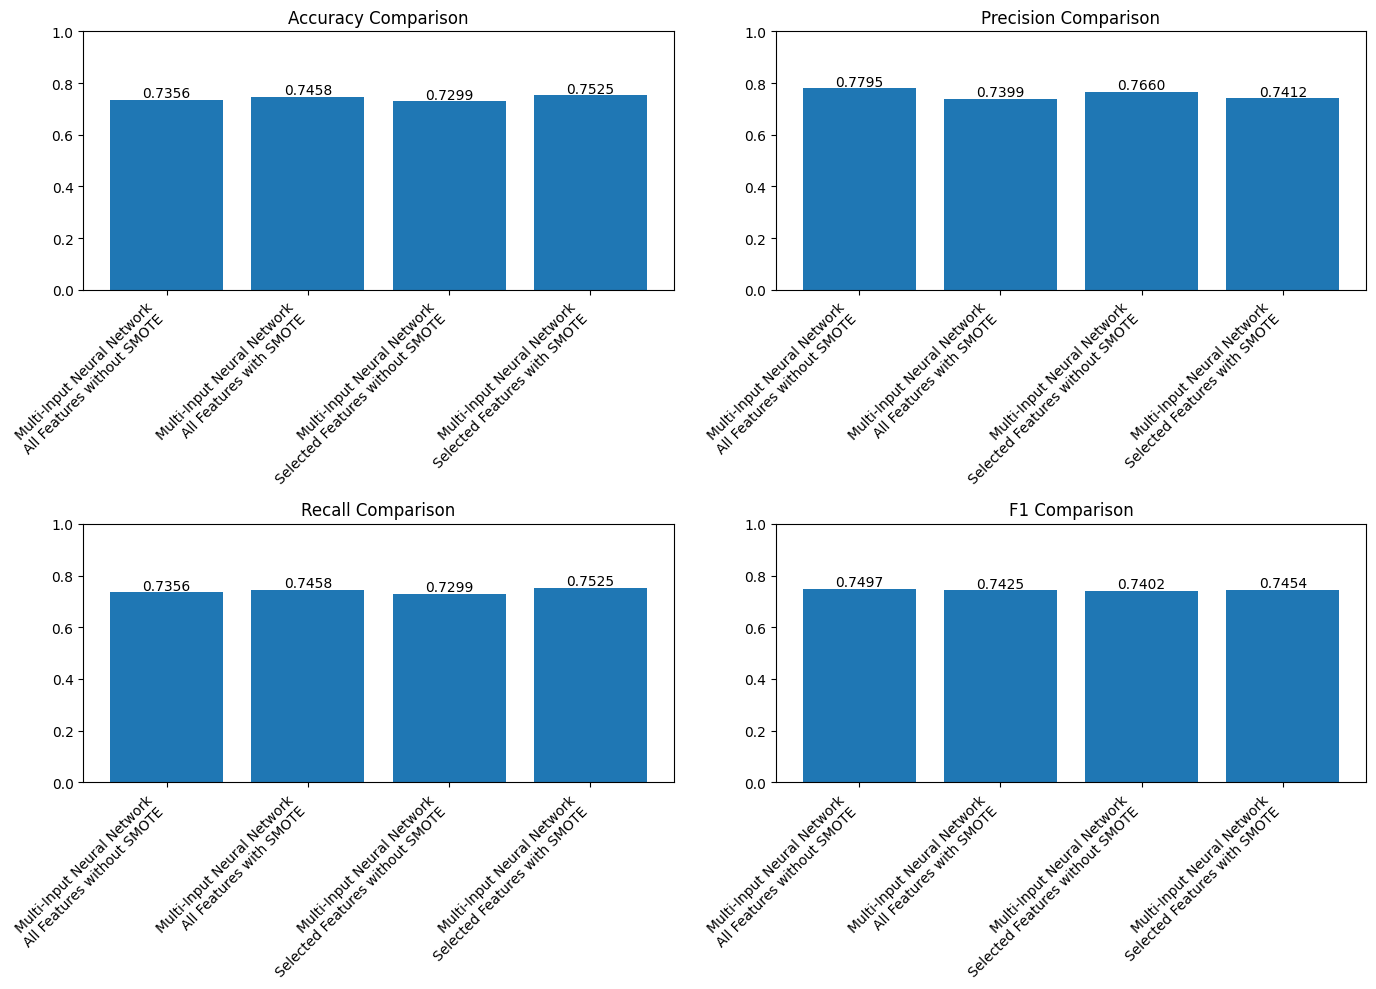

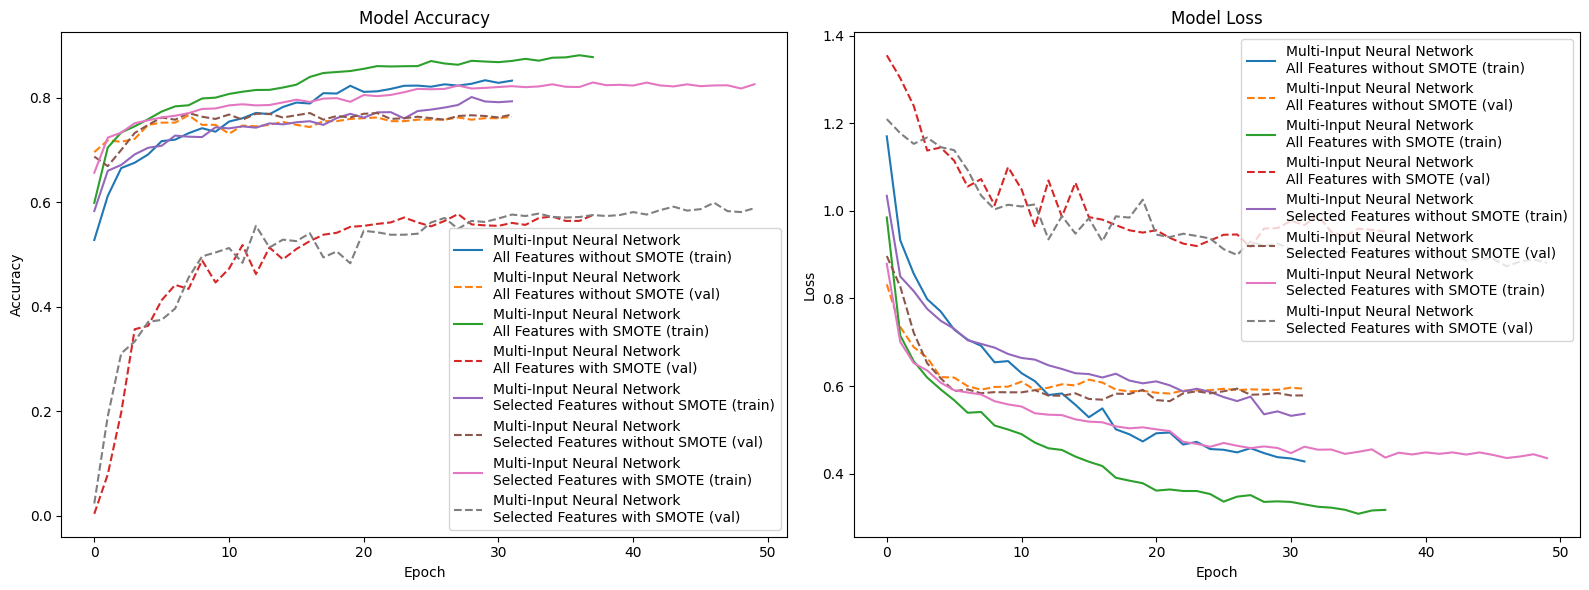

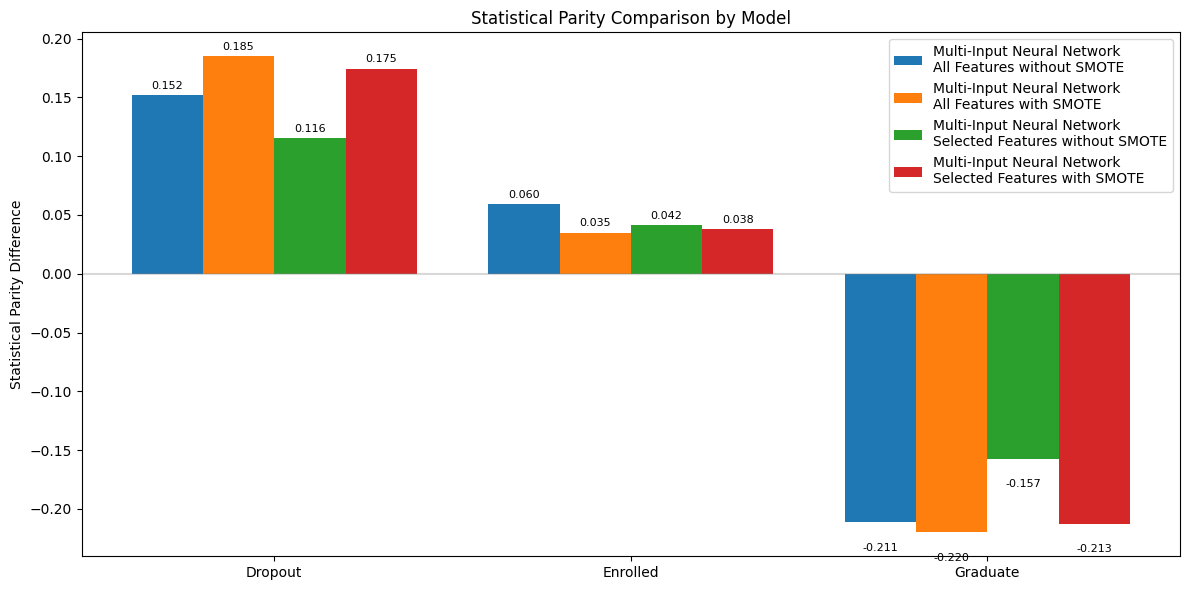

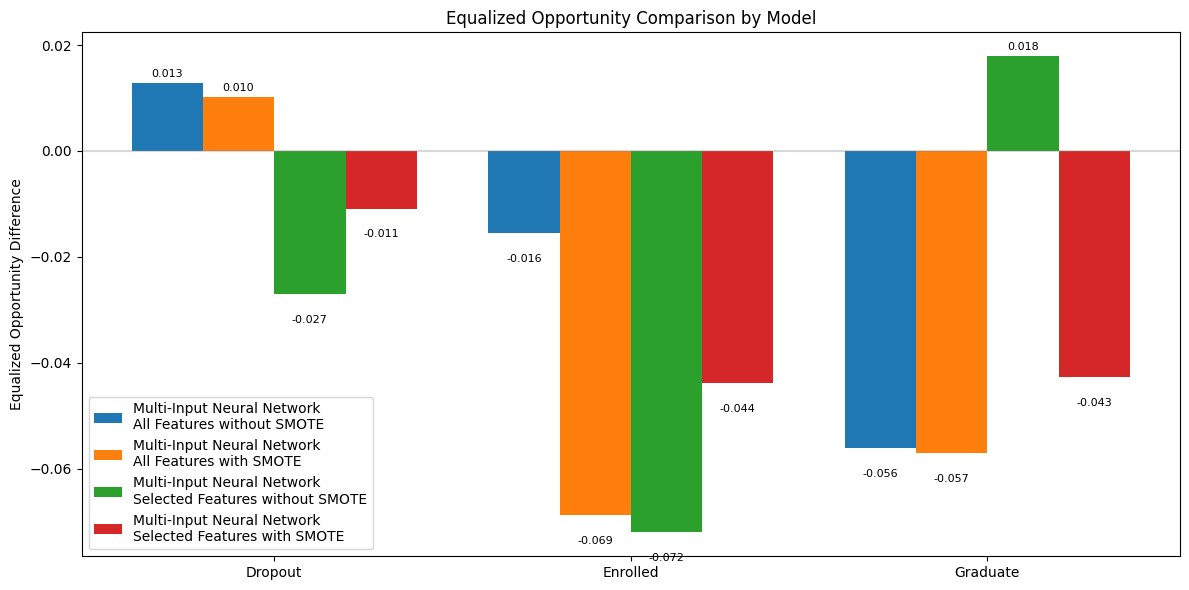

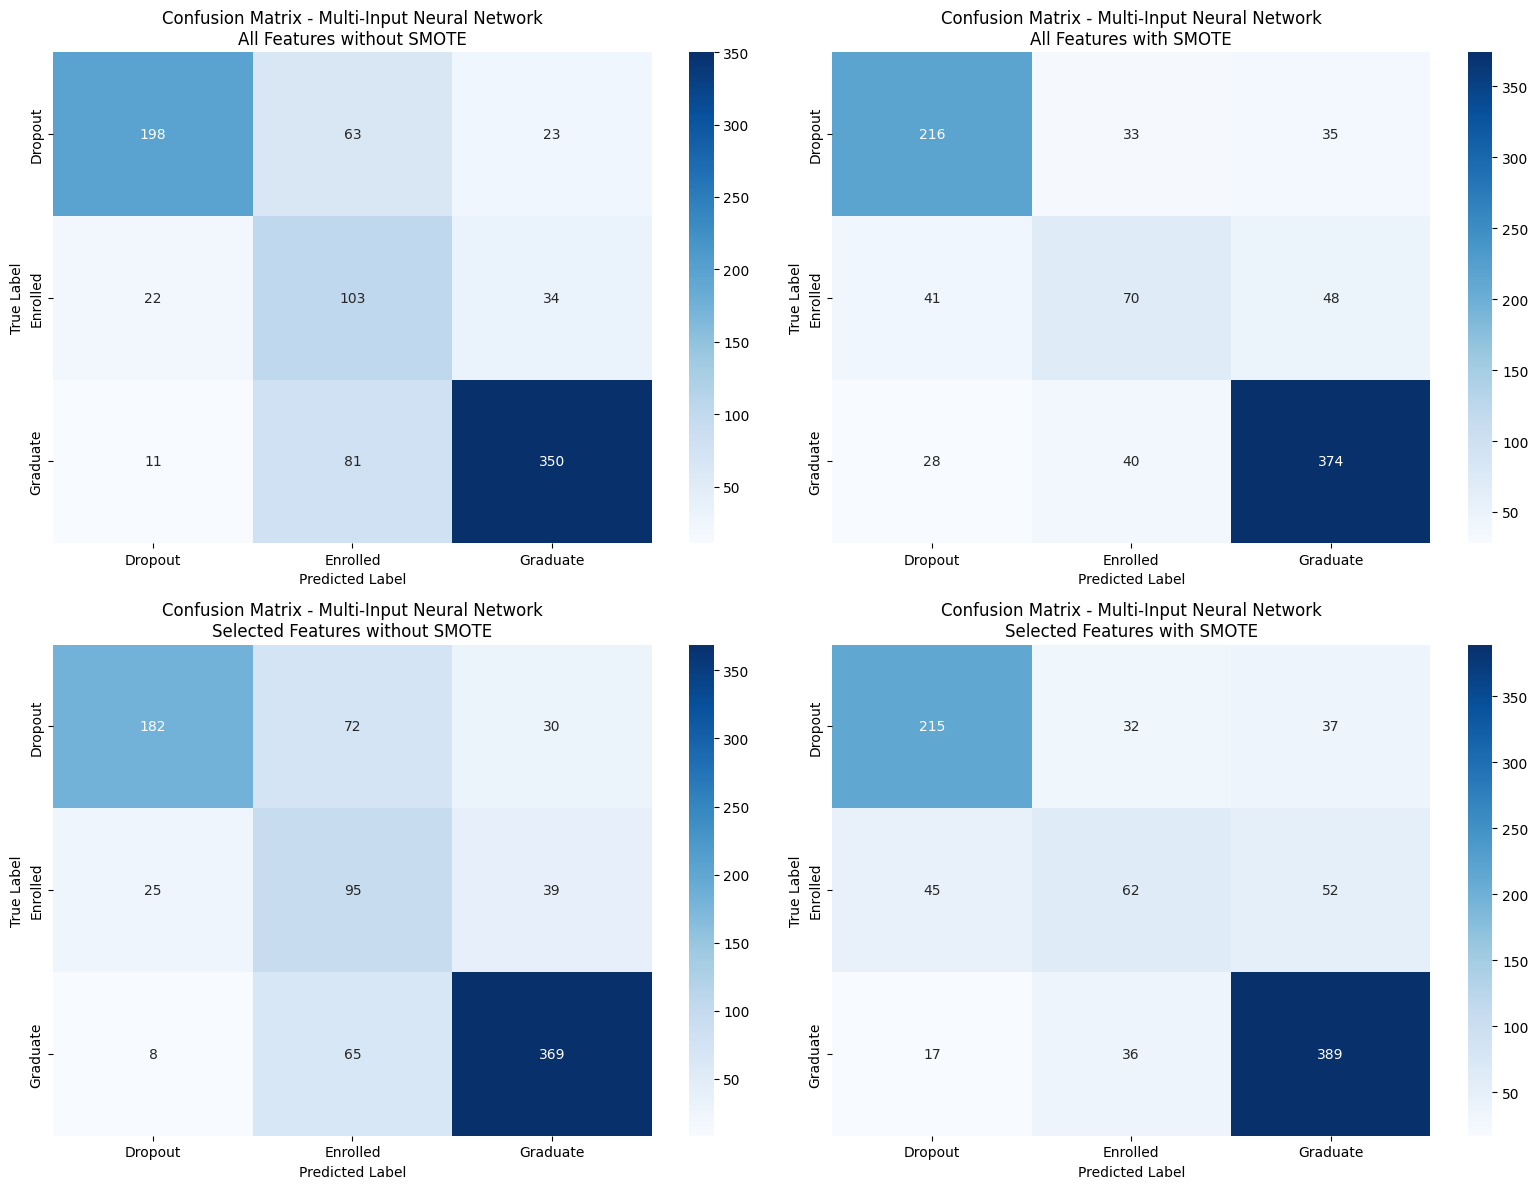


=== MODEL COMPARISON SUMMARY ===



,Model,Features,SMOTE,Total Features,Categorical Features,Binary Features,Numerical Features,Accuracy,Precision,Recall,F1 Score,SPD (Dropout),EO (Dropout),SPD (Enrolled),EO (Enrolled),SPD (Graduate),EO (Graduate)
0,Multi-Input Neural Network\nAll Features witho...,All,No,35,10,7,18,0.7356,0.7795,0.7356,0.7497,0.1517,0.0128,0.0596,-0.0155,-0.2113,-0.0561
1,Multi-Input Neural Network\nAll Features with ...,All,Yes,35,10,7,18,0.7458,0.7399,0.7458,0.7425,0.1851,0.0101,0.0350,-0.0688,-0.2201,-0.0570
2,Multi-Input Neural Network\nSelected Features ...,Selected,No,16,3,3,10,0.7299,0.7660,0.7299,0.7402,0.1157,-0.0271,0.0415,-0.0720,-0.1572,0.0179
3,Multi-Input Neural Network\nSelected Features ...,Selected,Yes,16,3,3,10,0.7525,0.7412,0.7525,0.7454,0.1745,-0.0109,0.0381,-0.0439,-0.2126,-0.0427


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Embedding, Flatten, Concatenate, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from imblearn.over_sampling import SMOTE
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Define model names
def get_model_name(feature_set, smote=False):
    feature_label = "All Features" if feature_set == "all_features" else "Selected Features"
    smote_label = "with SMOTE" if smote else "without SMOTE"
    return f"Multi-Input Neural Network\n{feature_label} {smote_label}"

# Define feature sets
def get_feature_sets():
    # All features
    all_features = {
        'categorical': [
            'Marital status',
            'Application mode',
            'Application order',
            'Course',
            'Previous qualification',
            'Nacionality',
            'Mother\'s qualification',
            'Father\'s qualification',
            'Mother\'s occupation',
            'Father\'s occupation'
        ],
        'binary': [
            'Tuition fees up to date',
            'Displaced',
            'Educational special needs',
            'Debtor',
            'Gender',
            'Scholarship holder',
            'International'
        ],
        'numerical': [
            'Previous qualification (grade)',
            'Admission grade',
            'Age at enrollment',
            'Curricular units 1st sem (credited)',
            'Curricular units 1st sem (enrolled)',
            'Curricular units 1st sem (evaluations)',
            'Curricular units 1st sem (approved)',
            'Curricular units 1st sem (grade)',
            'Curricular units 1st sem (without evaluations)',
            'Curricular units 2nd sem (credited)',
            'Curricular units 2nd sem (enrolled)',
            'Curricular units 2nd sem (evaluations)',
            'Curricular units 2nd sem (approved)',
            'Curricular units 2nd sem (grade)',
            'Curricular units 2nd sem (without evaluations)',
            'Unemployment rate',
            'Inflation rate',
            'GDP'
        ]
    }
    
    # Selected features
    selected_features = {
        'categorical': [
            'Course',
            'Application mode',
            'Mother\'s qualification'
        ],
        'binary': [
            'Tuition fees up to date',
            'Debtor',
            'Scholarship holder'
        ],
        'numerical': [
            'Curricular units 2nd sem (approved)',
            'Curricular units 1st sem (approved)',
            'Curricular units 2nd sem (grade)',
            'Curricular units 2nd sem (evaluations)',
            'Curricular units 1st sem (evaluations)',
            'Curricular units 2nd sem (enrolled)',
            'Admission grade',
            'Curricular units 1st sem (credited)',
            'Previous qualification (grade)',
            'Curricular units 1st sem (grade)'
        ]
    }
    
    return {
        'all_features': all_features,
        'selected_features': selected_features
    }

# Load and prepare data with SMOTE option
def load_and_prepare_data(feature_set, df, use_smote=False):
    # Combine feature types
    categorical_features = feature_set['categorical']
    binary_features = feature_set['binary']
    numerical_features = feature_set['numerical']
    all_features = categorical_features + binary_features + numerical_features
    
    # Select appropriate columns from dataframe
    X = df[all_features]
    y = df['Target']
    
    # Encode the target
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)
    num_classes = len(label_encoder.classes_)
    
    # Split data
    X_train, X_test, y_train_encoded, y_test_encoded = train_test_split(
        X, y_encoded, test_size=0.2, random_state=42, stratify=y
    )
    
    # Process categorical features
    categorical_encoders = {}
    categorical_dims = {}
    categorical_unique_values = {}
    
    for feature in categorical_features:
        # Handle the issue of unknown classes by encoding on the full dataset
        encoder = LabelEncoder()
        all_values = pd.concat([X_train[feature], X_test[feature]])
        encoder.fit(all_values)
        
        # Transform both train and test
        X_train[feature] = encoder.transform(X_train[feature])
        X_test[feature] = encoder.transform(X_test[feature])
        
        # Store encoder and dimensions
        categorical_encoders[feature] = encoder
        n_unique = len(encoder.classes_)
        categorical_unique_values[feature] = n_unique
        
        # Calculate embedding dimension
        embed_dim = min(50, (n_unique + 1) // 2)
        categorical_dims[feature] = embed_dim
    
    # Scale numerical features
    numerical_scaler = StandardScaler()
    if numerical_features:
        X_train[numerical_features] = numerical_scaler.fit_transform(X_train[numerical_features])
        X_test[numerical_features] = numerical_scaler.transform(X_test[numerical_features])
    
    # Apply SMOTE if requested
    if use_smote:
        print("Class distribution before SMOTE:")
        counter = Counter(y_train_encoded)
        for class_idx, count in counter.items():
            print(f"Class {label_encoder.classes_[class_idx]}: {count} ({count/len(y_train_encoded)*100:.2f}%)")
        
        # Apply SMOTE to balance classes
        smote = SMOTE(random_state=42)
        X_train_values = X_train.values
        X_train_resampled, y_train_resampled = smote.fit_resample(X_train_values, y_train_encoded)
        
        # Convert back to DataFrame to maintain column names
        X_train = pd.DataFrame(X_train_resampled, columns=X_train.columns)
        y_train_encoded = y_train_resampled
        
        print("\nClass distribution after SMOTE:")
        counter = Counter(y_train_encoded)
        for class_idx, count in counter.items():
            print(f"Class {label_encoder.classes_[class_idx]}: {count} ({count/len(y_train_encoded)*100:.2f}%)")
    
    # Convert to categorical for deep learning
    y_train = to_categorical(y_train_encoded)
    y_test = to_categorical(y_test_encoded)
    
    # Prepare model inputs
    def prepare_model_inputs(X_data):
        model_inputs = []
        
        # Categorical features
        for feature in categorical_features:
            model_inputs.append(X_data[feature].values.reshape(-1, 1))
        
        # Binary features
        for feature in binary_features:
            model_inputs.append(X_data[feature].values.reshape(-1, 1))
        
        # Numerical features (as a single input)
        if numerical_features:
            model_inputs.append(X_data[numerical_features].values)
        
        return model_inputs
    
    train_inputs = prepare_model_inputs(X_train)
    test_inputs = prepare_model_inputs(X_test)
    
    # Calculate class weights (might be redundant if using SMOTE, but keeping for flexibility)
    class_weights = None
    if not use_smote:  # Only use class weights if not using SMOTE
        from sklearn.utils import class_weight
        class_weights = class_weight.compute_class_weight(
            class_weight='balanced',
            classes=np.unique(y_train_encoded),
            y=y_train_encoded
        )
        class_weights = {i: weight for i, weight in enumerate(class_weights)}
    
    # Return all necessary data
    return {
        'X_train': X_train,
        'X_test': X_test,
        'y_train': y_train,
        'y_test': y_test,
        'y_train_encoded': y_train_encoded,
        'y_test_encoded': y_test_encoded,
        'train_inputs': train_inputs,
        'test_inputs': test_inputs,
        'categorical_features': categorical_features,
        'binary_features': binary_features,
        'numerical_features': numerical_features,
        'categorical_encoders': categorical_encoders,
        'categorical_dims': categorical_dims,
        'categorical_unique_values': categorical_unique_values,
        'numerical_scaler': numerical_scaler,
        'label_encoder': label_encoder,
        'class_weights': class_weights,
        'num_classes': num_classes,
        'X_test_index': X_test.index,  # For fairness metrics later
        'used_smote': use_smote  # Track if SMOTE was used
    }

# Build model
def build_model(data_dict):
    categorical_features = data_dict['categorical_features']
    binary_features = data_dict['binary_features']
    numerical_features = data_dict['numerical_features']
    categorical_unique_values = data_dict['categorical_unique_values']
    categorical_dims = data_dict['categorical_dims']
    num_classes = data_dict['num_classes']
    
    inputs = []
    embeddings = []
    
    # Process categorical features with embeddings
    for feature in categorical_features:
        input_dim = categorical_unique_values[feature]
        output_dim = categorical_dims[feature]
        
        # Create a valid layer name
        clean_name = feature.replace(' ', '_').replace('\'', '').replace('(', '').replace(')', '').replace('/', '_')
        
        # Input layer for this categorical feature
        inp = Input(shape=(1,), name=f'input_{clean_name}')
        inputs.append(inp)
        
        # Embedding layer
        emb = Embedding(input_dim=input_dim, output_dim=output_dim, 
                       name=f'embedding_{clean_name}')(inp)
        emb = Flatten(name=f'flatten_{clean_name}')(emb)
        embeddings.append(emb)
    
    # Process binary features
    for feature in binary_features:
        clean_name = feature.replace(' ', '_').replace('\'', '').replace('(', '').replace(')', '').replace('/', '_')
        inp = Input(shape=(1,), name=f'input_{clean_name}')
        inputs.append(inp)
        embeddings.append(inp)
    
    # Process numerical features
    if numerical_features:
        numerical_input = Input(shape=(len(numerical_features),), name='input_numerical')
        inputs.append(numerical_input)
        embeddings.append(numerical_input)
    
    # Combine all feature representations
    if len(embeddings) > 1:
        x = Concatenate()(embeddings)
    else:
        x = embeddings[0]
    
    # Deep layers
    x = Dense(128, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    
    x = Dense(64, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    
    x = Dense(32, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    
    # Output layer
    output = Dense(num_classes, activation='softmax')(x)
    
    # Create model
    model = Model(inputs=inputs, outputs=output)
    
    # Compile model
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Train model (modified to handle SMOTE case and not save models to disk)
def train_model(model, data_dict, model_name):
    callbacks = [
        EarlyStopping(
            monitor='val_loss',
            patience=10,
            restore_best_weights=True,
            verbose=1
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.2,
            patience=5,
            min_lr=0.0001,
            verbose=1
        )
        # ModelCheckpoint removed to avoid saving files
    ]
    
    # Determine whether to use class weights based on SMOTE usage
    class_weights = data_dict['class_weights'] if not data_dict['used_smote'] else None
    
    # Fit the model
    history = model.fit(
        data_dict['train_inputs'], 
        data_dict['y_train'],
        validation_split=0.2,
        epochs=50,
        batch_size=32,
        callbacks=callbacks,
        class_weight=class_weights,  # Will be None if SMOTE was used
        verbose=1
    )
    
    return model, history

# Evaluate model
def evaluate_model(model, data_dict, df):
    y_test = data_dict['y_test']
    test_inputs = data_dict['test_inputs']
    label_encoder = data_dict['label_encoder']
    
    # Evaluate on test set
    test_loss, test_accuracy = model.evaluate(test_inputs, y_test, verbose=0)
    
    # Predict classes
    y_pred_prob = model.predict(test_inputs)
    y_pred = np.argmax(y_pred_prob, axis=1)
    y_true = np.argmax(y_test, axis=1)
    
    # Performance metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    
    # Classification report
    class_report = classification_report(y_true, y_pred, 
                                         target_names=label_encoder.classes_,
                                         output_dict=True)
    
    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Calculate fairness metrics
    # Extract gender from original dataset using test indices
    gender = df['Gender'].iloc[data_dict['X_test_index']].values
    class_names = label_encoder.classes_
    
    # Statistical Parity Difference (SPD)
    spd_results = {}
    for class_idx, class_name in enumerate(class_names):
        privileged_selection = np.mean(y_pred[gender == 1] == class_idx)
        unprivileged_selection = np.mean(y_pred[gender == 0] == class_idx)
        spd = privileged_selection - unprivileged_selection
        
        spd_results[class_name] = {
            'privileged_selection_rate': privileged_selection,
            'unprivileged_selection_rate': unprivileged_selection,
            'statistical_parity_difference': spd
        }
    
    # Equalized Opportunity (EO)
    eo_results = {}
    for class_idx, class_name in enumerate(class_names):
        y_true_binary = (y_true == class_idx)
        y_pred_binary = (y_pred == class_idx)
        
        privileged_mask = (gender == 1) & y_true_binary
        if np.sum(privileged_mask) > 0:
            privileged_tpr = np.sum(y_pred_binary[privileged_mask]) / np.sum(privileged_mask)
        else:
            privileged_tpr = 0
        
        unprivileged_mask = (gender == 0) & y_true_binary
        if np.sum(unprivileged_mask) > 0:
            unprivileged_tpr = np.sum(y_pred_binary[unprivileged_mask]) / np.sum(unprivileged_mask)
        else:
            unprivileged_tpr = 0
        
        eo = privileged_tpr - unprivileged_tpr
        
        eo_results[class_name] = {
            'privileged_tpr': privileged_tpr,
            'unprivileged_tpr': unprivileged_tpr,
            'equalized_opportunity_difference': eo
        }
    
    # Return all evaluation metrics
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'classification_report': class_report,
        'confusion_matrix': cm,
        'y_pred': y_pred,
        'y_true': y_true,
        'statistical_parity': spd_results,
        'equalized_opportunity': eo_results
    }

# Visualize results (modified to use model display names and not save files)
def plot_results(results_dict, histories, display_names):
    models = list(results_dict.keys())
    
    # Performance metrics comparison
    metrics = ['accuracy', 'precision', 'recall', 'f1']
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    axes = axes.flatten()
    
    for i, metric in enumerate(metrics):
        values = [results_dict[model][metric] for model in models]
        axes[i].bar(range(len(models)), values)
        axes[i].set_title(f'{metric.capitalize()} Comparison')
        axes[i].set_ylim(0, 1)
        axes[i].set_xticks(range(len(models)))
        axes[i].set_xticklabels([display_names[model] for model in models], rotation=45, ha='right')
        
        # Add value labels
        for j, v in enumerate(values):
            axes[i].text(j, v + 0.01, f"{v:.4f}", ha='center')
    
    plt.tight_layout()
    plt.show()
    
    # Learning curves comparison
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Accuracy
    for model in models:
        axes[0].plot(histories[model].history['accuracy'], label=f'{display_names[model]} (train)')
        axes[0].plot(histories[model].history['val_accuracy'], label=f'{display_names[model]} (val)', linestyle='--')
    
    axes[0].set_title('Model Accuracy')
    axes[0].set_ylabel('Accuracy')
    axes[0].set_xlabel('Epoch')
    axes[0].legend()
    
    # Loss
    for model in models:
        axes[1].plot(histories[model].history['loss'], label=f'{display_names[model]} (train)')
        axes[1].plot(histories[model].history['val_loss'], label=f'{display_names[model]} (val)', linestyle='--')
    
    axes[1].set_title('Model Loss')
    axes[1].set_ylabel('Loss')
    axes[1].set_xlabel('Epoch')
    axes[1].legend()
    
    plt.tight_layout()
    plt.show()
    
    # Fairness metrics comparison
    class_names = list(results_dict[models[0]]['statistical_parity'].keys())
    
    # Statistical Parity
    fig, ax = plt.subplots(figsize=(12, 6))
    x = np.arange(len(class_names))
    width = 0.2  # Adjust bar width based on number of models
    
    spd_values = {}
    for model in models:
        spd_values[model] = [results_dict[model]['statistical_parity'][class_name]['statistical_parity_difference'] 
                             for class_name in class_names]
    
    for i, model in enumerate(models):
        offset = width * (i - len(models)/2 + 0.5)
        rects = ax.bar(x + offset, spd_values[model], width, label=display_names[model])
        
        # Add value labels
        for rect in rects:
            height = rect.get_height()
            ax.annotate(f'{height:.3f}',
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3 if height >= 0 else -15),
                        textcoords="offset points",
                        ha='center', va='bottom' if height >= 0 else 'top',
                        fontsize=8)
    
    ax.set_ylabel('Statistical Parity Difference')
    ax.set_title('Statistical Parity Comparison by Model')
    ax.set_xticks(x)
    ax.set_xticklabels(class_names)
    ax.legend()
    ax.axhline(y=0, color='gray', linestyle='-', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Equalized Opportunity
    fig, ax = plt.subplots(figsize=(12, 6))
    
    eo_values = {}
    for model in models:
        eo_values[model] = [results_dict[model]['equalized_opportunity'][class_name]['equalized_opportunity_difference'] 
                             for class_name in class_names]
    
    for i, model in enumerate(models):
        offset = width * (i - len(models)/2 + 0.5)
        rects = ax.bar(x + offset, eo_values[model], width, label=display_names[model])
        
        # Add value labels
        for rect in rects:
            height = rect.get_height()
            ax.annotate(f'{height:.3f}',
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3 if height >= 0 else -15),
                        textcoords="offset points",
                        ha='center', va='bottom' if height >= 0 else 'top',
                        fontsize=8)
    
    ax.set_ylabel('Equalized Opportunity Difference')
    ax.set_title('Equalized Opportunity Comparison by Model')
    ax.set_xticks(x)
    ax.set_xticklabels(class_names)
    ax.legend()
    ax.axhline(y=0, color='gray', linestyle='-', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Confusion matrices
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    axes = axes.flatten()
    
    for i, model in enumerate(models):
        cm = results_dict[model]['confusion_matrix']
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                  xticklabels=class_names,
                  yticklabels=class_names, ax=axes[i])
        axes[i].set_title(f'Confusion Matrix - {display_names[model]}')
        axes[i].set_ylabel('True Label')
        axes[i].set_xlabel('Predicted Label')
    
    plt.tight_layout()
    plt.show()

# Function to display summary table
def display_summary_table(results_dict, data_dicts, display_names):
    # Create a DataFrame to hold all metrics
    metrics_data = []
    
    for model_key in results_dict.keys():
        model_results = results_dict[model_key]
        model_data = data_dicts[model_key]
        
        # Basic metrics
        model_metrics = {
            'Model': display_names[model_key],
            'Features': 'All' if 'all_features' in model_key else 'Selected',
            'SMOTE': 'Yes' if model_data['used_smote'] else 'No',
            'Accuracy': f"{model_results['accuracy']:.4f}",
            'Precision': f"{model_results['precision']:.4f}",
            'Recall': f"{model_results['recall']:.4f}",
            'F1 Score': f"{model_results['f1']:.4f}"
        }
        
        # Add fairness metrics
        class_names = list(model_results['statistical_parity'].keys())
        for class_name in class_names:
            spd = model_results['statistical_parity'][class_name]['statistical_parity_difference']
            eo = model_results['equalized_opportunity'][class_name]['equalized_opportunity_difference']
            
            model_metrics[f'SPD ({class_name})'] = f"{spd:.4f}"
            model_metrics[f'EO ({class_name})'] = f"{eo:.4f}"
        
        # Add feature counts
        categorical_count = len(model_data['categorical_features'])
        binary_count = len(model_data['binary_features'])
        numerical_count = len(model_data['numerical_features'])
        total_count = categorical_count + binary_count + numerical_count
        
        model_metrics['Categorical Features'] = categorical_count
        model_metrics['Binary Features'] = binary_count
        model_metrics['Numerical Features'] = numerical_count
        model_metrics['Total Features'] = total_count
        
        metrics_data.append(model_metrics)
    
    # Create DataFrame and display
    df_metrics = pd.DataFrame(metrics_data)
    
    # Reorder columns for better presentation
    basic_cols = ['Model', 'Features', 'SMOTE', 'Total Features', 
                 'Categorical Features', 'Binary Features', 'Numerical Features']
    performance_cols = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
    
    fairness_cols = [col for col in df_metrics.columns 
                    if col.startswith('SPD') or col.startswith('EO')]
    
    ordered_cols = basic_cols + performance_cols + fairness_cols
    df_metrics = df_metrics[ordered_cols]
    
    # Display the table
    from IPython.display import display
    print("\n=== MODEL COMPARISON SUMMARY ===\n")
    display(df_metrics)
    
    # Return the DataFrame in case it's needed elsewhere
    return df_metrics

# Main execution
from sklearn.utils import class_weight

# Load dataset
df = pd.read_csv('data.csv', sep=';')
print(f"Dataset shape: {df.shape}")

# Get feature sets
feature_sets = get_feature_sets()

# Dictionary to store data for each model
data_dicts = {}
models = {}
histories = {}
results = {}
display_names = {}

# Process both feature sets with and without SMOTE
for name, feature_set in feature_sets.items():
    # Without SMOTE
    normal_name = f"{name}"
    display_names[normal_name] = get_model_name(name, False)
    print(f"\nProcessing {display_names[normal_name]}...")
    
    # Prepare data without SMOTE
    data_dicts[normal_name] = load_and_prepare_data(feature_set, df, use_smote=False)
    
    # Build model
    models[normal_name] = build_model(data_dicts[normal_name])
    
    # Train model
    models[normal_name], histories[normal_name] = train_model(models[normal_name], data_dicts[normal_name], normal_name)
    
    # Evaluate model
    results[normal_name] = evaluate_model(models[normal_name], data_dicts[normal_name], df)
    
    print(f"\n{display_names[normal_name]} Results:")
    print(f"Accuracy: {results[normal_name]['accuracy']:.4f}")
    print(f"F1 Score: {results[normal_name]['f1']:.4f}")
    
    # With SMOTE
    smote_name = f"{name}_smote"
    display_names[smote_name] = get_model_name(name, True)
    print(f"\nProcessing {display_names[smote_name]}...")
    
    # Prepare data with SMOTE
    data_dicts[smote_name] = load_and_prepare_data(feature_set, df, use_smote=True)
    
    # Build model
    models[smote_name] = build_model(data_dicts[smote_name])
    
    # Train model
    models[smote_name], histories[smote_name] = train_model(models[smote_name], data_dicts[smote_name], smote_name)
    
    # Evaluate model
    results[smote_name] = evaluate_model(models[smote_name], data_dicts[smote_name], df)
    
    print(f"\n{display_names[smote_name]} Results:")
    print(f"Accuracy: {results[smote_name]['accuracy']:.4f}")
    print(f"F1 Score: {results[smote_name]['f1']:.4f}")

# Visualize and compare results
plot_results(results, histories, display_names)

# Display summary table
metrics_df = display_summary_table(results, data_dicts, display_names)

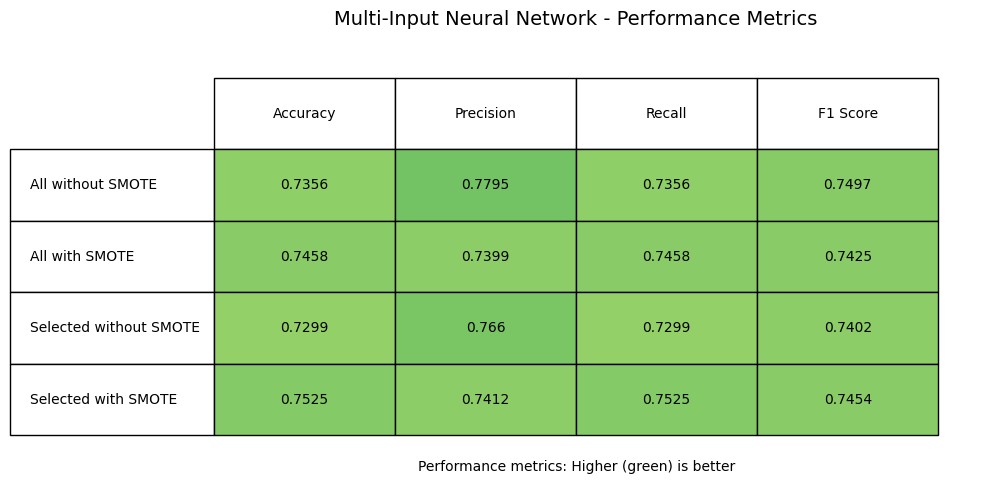

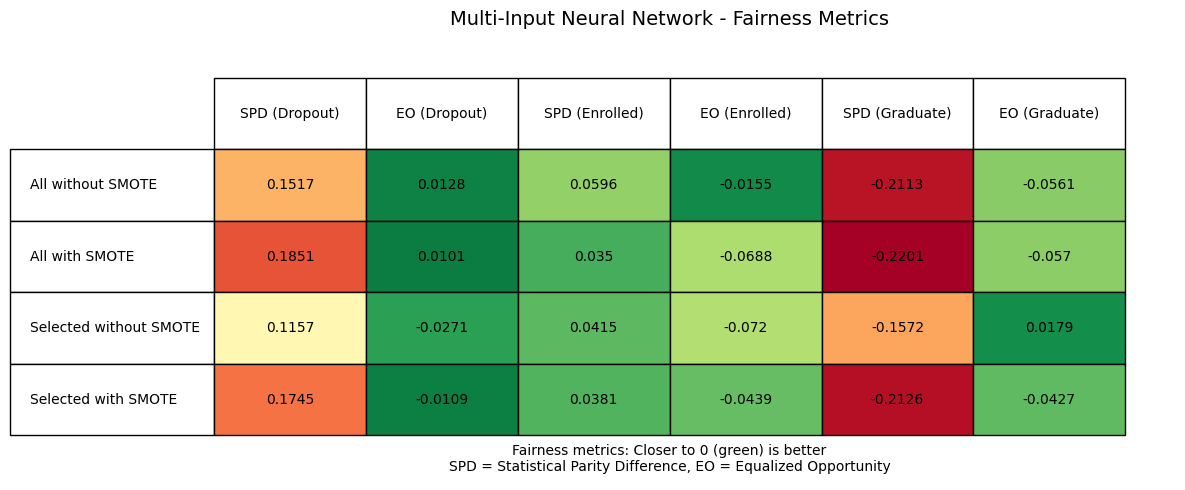

In [10]:
def plot_summary_tables(results_dict, data_dicts, display_names):
    # Create a DataFrame to hold all metrics
    metrics_data = []
    
    for model_key in results_dict.keys():
        model_results = results_dict[model_key]
        model_data = data_dicts[model_key]
        
        # Basic metrics
        model_metrics = {
            'Model': display_names[model_key],
            'Features': 'All' if 'all_features' in model_key else 'Selected',
            'SMOTE': 'Yes' if model_data['used_smote'] else 'No',
            'Accuracy': model_results['accuracy'],
            'Precision': model_results['precision'],
            'Recall': model_results['recall'],
            'F1 Score': model_results['f1']
        }
        
        # Add fairness metrics
        class_names = list(model_results['statistical_parity'].keys())
        for class_name in class_names:
            spd = model_results['statistical_parity'][class_name]['statistical_parity_difference']
            eo = model_results['equalized_opportunity'][class_name]['equalized_opportunity_difference']
            
            model_metrics[f'SPD ({class_name})'] = spd
            model_metrics[f'EO ({class_name})'] = eo
        
        metrics_data.append(model_metrics)
    
    # Create DataFrame
    df_metrics = pd.DataFrame(metrics_data)
    
    # Extract model identifiers for row labels
    row_labels = [f"{m['Features']} {'with' if m['SMOTE']=='Yes' else 'without'} SMOTE" 
                  for m in metrics_data]
    
    # Prepare data for heatmap - exclude non-numeric columns
    plot_data = df_metrics.drop(['Model', 'Features', 'SMOTE'], axis=1)
    
    # Create separate dataframes for performance and fairness metrics
    fairness_cols = [col for col in plot_data.columns if col.startswith('SPD') or col.startswith('EO')]
    performance_cols = [col for col in plot_data.columns if col not in fairness_cols]
    
    perf_data = plot_data[performance_cols].copy()
    fair_data = plot_data[fairness_cols].copy()
    
    # 1. PLOT FOR PERFORMANCE METRICS
    fig1, ax1 = plt.subplots(figsize=(10, 5))
    
    # Performance metrics colormap (higher is better)
    norm_perf = plt.Normalize(vmin=0, vmax=1)
    
    # Create a table for performance metrics
    performance_table = ax1.table(
        cellText=np.round(perf_data.values, 4),
        rowLabels=row_labels,
        colLabels=perf_data.columns,
        cellColours=plt.cm.RdYlGn(norm_perf(perf_data.values)),
        loc='center',
        cellLoc='center',
        bbox=[0.05, 0.1, 0.9, 0.8]
    )
    performance_table.auto_set_font_size(False)
    performance_table.set_fontsize(10)
    performance_table.scale(1, 1.8)
    
    ax1.set_title('Multi-Input Neural Network - Performance Metrics', fontsize=14)
    ax1.text(0.5, 0.02, "Performance metrics: Higher (green) is better", 
             fontsize=10, ha='center', transform=ax1.transAxes)
    ax1.axis('off')
    plt.tight_layout()
    plt.show()
    
    # 2. PLOT FOR FAIRNESS METRICS
    fig2, ax2 = plt.subplots(figsize=(12, 5))
    
    # Convert fairness metrics to absolute values for coloring (closer to 0 is better)
    fair_data_abs = fair_data.abs()
    fair_max = fair_data_abs.values.max()
    fair_norm = plt.Normalize(vmin=0, vmax=fair_max)
    
    # Reverse the colormap so 0 (good) is green and larger values (worse) are red
    fairness_colors = plt.cm.RdYlGn_r(fair_norm(fair_data_abs.values))
    
    fairness_table = ax2.table(
        cellText=np.round(fair_data.values, 4),
        rowLabels=row_labels,
        colLabels=fair_data.columns,
        cellColours=fairness_colors,
        loc='center',
        cellLoc='center',
        bbox=[0.05, 0.1, 0.9, 0.8]
    )
    fairness_table.auto_set_font_size(False)
    fairness_table.set_fontsize(10)
    fairness_table.scale(1, 1.8)
    
    ax2.set_title('Multi-Input Neural Network - Fairness Metrics', fontsize=14)
    ax2.text(0.5, 0.02, 
             "Fairness metrics: Closer to 0 (green) is better\nSPD = Statistical Parity Difference, EO = Equalized Opportunity", 
             fontsize=10, ha='center', transform=ax2.transAxes)
    ax2.axis('off')
    plt.tight_layout()
    plt.show()

    return df_metrics
# Display summary tables as separate plots
metrics_df = plot_summary_tables(results, data_dicts, display_names)